In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Load the data

In [2]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [3]:
y.shape, tx.shape

((10000,), (10000, 2))

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function

Questions : 
1. The two columns represent the constant term (intercept) and the height feature.
2. Each row corresponds to a data sample
3. This is typically used to add a bias term (intercept) to the linear regression model. Each one corresponds to the constant term in the linear equation.
4. y.shape would be (3,) and tx.shape would be (3,2). Finally $\tilde{X}_{32}$ would represent the height of the third people
5. See the comment in the file "AD_comments.ipynb"
6. See above, yes they make sense !
7. See the sheet in the Ipad


Fill in the `compute_loss` function below:

In [4]:
def compute_loss(y, tx, w):
    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    # ***************************************************
    N = tx.shape[0]
    e = y - np.dot(tx, w)
    MSE = (1/2*N) * np.dot(e.T,e) # AD : alternative : np.dot(e,e) = np.linalg.norm(e)**2
    return MSE

    # TODO: compute loss by MSE
    # ***************************************************

    # AD : Good Implementation - See the results in the section Grid Search

In [5]:
w_test = np.array([1, 2])
compute_loss(y, tx, w_test.T)

269448336588.70837

# 2. Grid Search

Fill in the function `grid_search()` below:

In [6]:
# from costs import *


def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.

    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """

    losses = np.zeros((len(grid_w0), len(grid_w1)))
    # ***************************************************
    for i in range(len(grid_w0)) :  
        for j in range(len(grid_w1)) :
            w_grid = np.array([grid_w0[i], grid_w1[j]]) # AD : I create an array with the value of grid_w0 and grid_w1
            losses[i,j] = compute_loss(y, tx, w_grid.T)
    return losses

    # TODO: compute loss for each combination of w0 and w1.
    # ***************************************************


Let us play with the grid search demo now!

Grid Search: loss*=1561008565.2488797, w0*=73.36683417085428, w1*=12.8140703517588, execution time=2.757 seconds


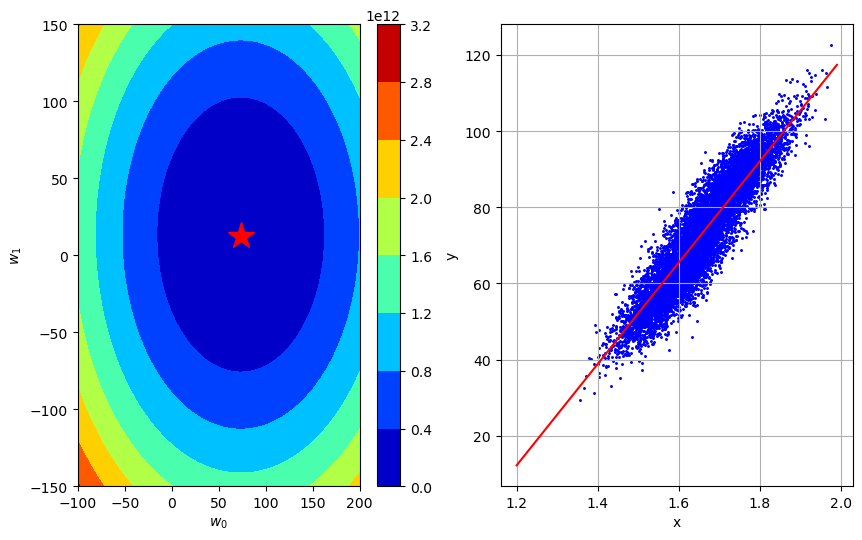

In [7]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=200) #AD : Change here the number of param. to 50 instead.

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print(
    "Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
        l=loss_star, w0=w0_star, w1=w1_star, t=execution_time
    )
)

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0, 6.0)
fig.savefig("grid_plot")  # Optional saving

Questions : 
- b) No with a grid space of 10, it doesn't like a good estimate, the red line shloud be more over than that (in this situation we underestimate). But with a grid space of 50, we have a pretty good fitting.
- c) Discussion :
1. We need a fine grid (high grid space) - coarse mean "grossier" in french
2. With a grid space of 200 the fitting become more and more accurate 
3. It really affect it, I can't run my code with a grid space of 1000 for example

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [8]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    # ***************************************************
    N = y.shape[0]
    e = y - np.dot(tx, w) #same as before
    grad = (-1/N)*np.dot(tx.T,e)
    return np.transpose(grad)
    # TODO: compute gradient vector
    # ***************************************************

In [9]:
#Compute the gradient of :
w1 = np.array([100, 20])
grad1 = compute_gradient(y, tx, w1)
print(grad1)
print(np.linalg.norm(grad1))

w2 = np.array([50, 10])
grad2 = compute_gradient(y, tx, w2)
print(grad2)
print(np.linalg.norm(grad2))

[26.706078    6.52028757]
27.49052112929254
[-23.293922    -3.47971243]
23.552392678247738


Questions :
- b) ???

Please fill in the functions `gradient_descent` below:

In [10]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of GD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        gradient = compute_gradient(y,tx, w)
        loss = compute_loss(y, tx, w)
        
        # TODO: compute gradient and loss
        # ***************************************************
        # ***************************************************
        w = w - gamma*gradient
        
        # TODO: update w by gradient
        # ***************************************************

        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [11]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=279223671275.9167, w0=7.329392200210504, w1=1.3479712434989137
GD iter. 1/49: loss=226463505603.00037, w0=13.925845180399968, w1=2.561145362647917
GD iter. 2/49: loss=183727771407.93814, w0=19.86265286257048, w1=3.6530020698820245
GD iter. 3/49: loss=149111826709.93768, w0=25.205779776523947, w1=4.635673106392713
GD iter. 4/49: loss=121072911504.5573, w0=30.014593999082074, w1=5.520077039252335
GD iter. 5/49: loss=98361390188.19919, w0=34.34252679938438, w1=6.316040578825998
GD iter. 6/49: loss=79965057921.94913, w0=38.23766631965647, w1=7.032407764442294
GD iter. 7/49: loss=65064028786.286514, w0=41.743291887901336, w1=7.67713823149696
GD iter. 8/49: loss=52994195186.399864, w0=44.89835489932172, w1=8.257395651846164
GD iter. 9/49: loss=43217629970.49167, w0=47.73791160960007, w1=8.779627330160444
GD iter. 10/49: loss=35298612145.606, w0=50.29351264885058, w1=9.249635840643297
GD iter. 11/49: loss=28884207707.44862, w0=52.59355358417604, w1=9.672643500077871
GD ite

In [12]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

Questions :
- c) 
1. Yes, the cost is being minimized over the step !
2. Yes, the algorithm is converging and pretty fast (in 4-5 step it stabilize in the same order of magnitude)
3. The algorithm is converging so the values are good

- d) 
1. With the step size : 0.001, 0.01, 2, 2.5 the algorithm doesn't converges, it convergences only with the step size : 0,5, 1
2. Yes the procedure convergence for the three options but in different ways

# 4. Stochastic gradient descent

In [13]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from just few examples n and their corresponding y_n labels.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """
    # ***************************************************
    stoch_gradient = compute_gradient(y, tx, w)
    return stoch_gradient
    # TODO: implement stochastic gradient computation. It's the same as the usual gradient.
    # ***************************************************


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        # ***************************************************
        for y_batch, tx_batch in batch_iter(y, tx, batch_size=batch_size, num_batches=1) :
        
            grad = compute_stoch_gradient(y_batch, tx_batch, w)
            w = w - gamma*grad
            loss = compute_loss(y, tx, w)
            ws.append(w)
            losses.append(loss)
            
        # TODO: implement stochastic gradient descent.
        # ***************************************************

        print(
            "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [14]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=220486351162.83447, w0=8.054996032990458, w1=2.396491517069974
SGD iter. 1/49: loss=167666082045.40637, w0=16.017693557282485, w1=7.000243297247
SGD iter. 2/49: loss=134949704016.42628, w0=21.995652761100448, w1=7.420844762869572
SGD iter. 3/49: loss=114645220332.40938, w0=26.485195126595563, w1=5.0490707509609125
SGD iter. 4/49: loss=88248122517.63344, w0=31.66328826893615, w1=14.519428545154504
SGD iter. 5/49: loss=72399101728.21513, w0=35.87759136398702, w1=17.630430494031767
SGD iter. 6/49: loss=67713044160.63694, w0=38.22541886944983, w1=23.159030360856594
SGD iter. 7/49: loss=56929878912.66541, w0=41.516755549124156, w1=23.381100960604314
SGD iter. 8/49: loss=43874096554.05432, w0=45.027140972030125, w1=20.386176475380157
SGD iter. 9/49: loss=36961748721.95535, w0=48.163280206772036, w1=22.249777523464854
SGD iter. 10/49: loss=33563577600.024963, w0=50.14364716933296, w1=23.70539341133251
SGD iter. 11/49: loss=21838908771.028008, w0=53.75346615953431, w1=18.3

In [15]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses,
        sgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

Questions :
- For the SGD the computational cost is cheaper but it takes more iteration to converge to the optimum

# 5. Effect of Outliers and MAE Cost Function

In [16]:
import datetime
from helpers import *

# ***************************************************
height, weight, gender = load_data(sub_sample=True, add_outlier=False)
# height, weight, gender = load_data(sub_sample=True, add_outlier=True)
# TODO: reload the data by subsampling first, then by subsampling and adding outliers
# ***************************************************

x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [17]:
y.shape, tx.shape

((200,), (200, 2))

In [18]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

# ***************************************************
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma) # Copy-paste from the gradient descent section
# TODO: fit the model to the subsampled data / subsampled data with outliers and visualize the cloud of points
#       and the model fit
# ***************************************************

end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=113170888.97753663, w0=51.54259072181176, w1=10.132993413506084
GD iter. 1/49: loss=10682001.035117716, w0=67.0053679383553, w1=13.172891437557825
GD iter. 2/49: loss=1458001.1203000185, w0=71.64420110331838, w1=14.084860844773322
GD iter. 3/49: loss=627841.1279664254, w0=73.03585105280729, w1=14.358451666937965
GD iter. 4/49: loss=553126.728656403, w0=73.45334603765397, w1=14.440528913587356
GD iter. 5/49: loss=546402.4327185008, w0=73.57859453310797, w1=14.46515208758217
GD iter. 6/49: loss=545797.2460840897, w0=73.61616908174418, w1=14.472539039780616
GD iter. 7/49: loss=545742.7792869926, w0=73.62744144633503, w1=14.474755125440149
GD iter. 8/49: loss=545737.877275254, w0=73.63082315571229, w1=14.47541995113801
GD iter. 9/49: loss=545737.4360941977, w0=73.63183766852546, w1=14.475619398847368
GD iter. 10/49: loss=545737.3963879024, w0=73.63214202236942, w1=14.475679233160175
GD iter. 11/49: loss=545737.3928143359, w0=73.6322333285226, w1=14.475697183454017
GD it

In [19]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

Questions : 
- The outliers really influences the convergence of the this model, the optimal parameters are not the same in both situation (with and without outliers) 
- Without outliers : GD iter. 49/49: loss=545737.3924609063, w0=73.63227245973111, w1=14.475704876437092 - execution time=0.003 seconds
- With the 2 outliers : GD iter. 49/49: loss=2690237.5111066285, w0=74.06780585492636, w1=11.0348948659891 - execution time=0.007 seconds

# 6. Subgradient descent

In [20]:
def compute_loss_mae(y, tx, w):
    """Calculate the loss using MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    # ***************************************************
    N = tx.shape[0]
    e = y - tx@w 
    MAE = (1/2*N) * np.sum(np.abs(e))
    return MAE
    # TODO: compute loss by MAE
    # ***************************************************

In [21]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    # ***************************************************
    # We need to use the chain rule as mentioned in the instructions - see the explication in the exercise (Ipad)
    q_gradient = - tx
    e=y-tx@w
    dh=np.ones(len(y))
    dh[e>0]=1
    dh[e<0]=-1
    dh[e==0]=0
    subgrad_mae = dh@q_gradient/(2*len(y))
    return subgrad_mae
    # TODO: compute subgradient gradient vector for MAE
    # ***************************************************

In [22]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        subgradient = compute_subgradient_mae(y, tx, w)
        loss = compute_loss_mae(y, tx, w)
        
        # TODO: compute subgradient and loss
        # ***************************************************
        # ***************************************************
        w = w - gamma*subgradient
        
        # TODO: update w by subgradient
        # ***************************************************
        ws.append(w)
        losses.append(loss)
        print(
            "SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

In [23]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

SubGD iter. 0/499: loss=1472645.4491946227, w0=0.35, w1=8.447686994372815e-16
SubGD iter. 1/499: loss=1465645.449194623, w0=0.7, w1=1.689537398874563e-15
SubGD iter. 2/499: loss=1458645.4491946227, w0=1.0499999999999998, w1=2.5343060983118446e-15
SubGD iter. 3/499: loss=1451645.449194623, w0=1.4, w1=3.379074797749126e-15
SubGD iter. 4/499: loss=1444645.449194623, w0=1.75, w1=4.2238434971864075e-15
SubGD iter. 5/499: loss=1437645.449194623, w0=2.1, w1=5.068612196623689e-15
SubGD iter. 6/499: loss=1430645.449194623, w0=2.45, w1=5.913380896060971e-15
SubGD iter. 7/499: loss=1423645.4491946227, w0=2.8000000000000003, w1=6.758149595498253e-15
SubGD iter. 8/499: loss=1416645.449194623, w0=3.1500000000000004, w1=7.602918294935534e-15
SubGD iter. 9/499: loss=1409645.449194623, w0=3.5000000000000004, w1=8.447686994372815e-15
SubGD iter. 10/499: loss=1402645.4491946227, w0=3.8500000000000005, w1=9.292455693810096e-15
SubGD iter. 11/499: loss=1395645.449194623, w0=4.2, w1=1.0137224393247377e-14
S

In [24]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses,
        subgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [25]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic SubGradient Descent algorithm (SubSGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        # ***************************************************
        for y_batch, tx_batch in batch_iter(y, tx, batch_size=batch_size, num_batches=1) :
        
            grad = compute_subgradient_mae(y_batch, tx_batch, w)
            w = w - gamma*grad
            loss = compute_loss_mae(y, tx, w)
            ws.append(w)
            losses.append(loss)
        # TODO: implement stochastic subgradient descent.
        # ***************************************************
        
        print(
            "SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [26]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

SubSGD iter. 0/499: loss=1465645.449194623, w0=0.35, w1=0.226825536331064
SubSGD iter. 1/499: loss=1458645.449194623, w0=0.7, w1=-0.13653973849254258
SubSGD iter. 2/499: loss=1451645.449194623, w0=1.0499999999999998, w1=0.19690632131180513
SubSGD iter. 3/499: loss=1444645.4491946232, w0=1.4, w1=-0.18423266425297807
SubSGD iter. 4/499: loss=1437645.449194623, w0=1.75, w1=0.22076445930001865
SubSGD iter. 5/499: loss=1430645.449194623, w0=2.1, w1=0.330741015640327
SubSGD iter. 6/499: loss=1423645.449194623, w0=2.45, w1=0.20243787907847488
SubSGD iter. 7/499: loss=1416645.4491946227, w0=2.8000000000000003, w1=0.8052959194590334
SubSGD iter. 8/499: loss=1409645.4491946227, w0=3.1500000000000004, w1=0.7271991745544539
SubSGD iter. 9/499: loss=1402645.449194623, w0=3.5000000000000004, w1=0.14093900993230968
SubSGD iter. 10/499: loss=1395645.4491946232, w0=3.8500000000000005, w1=-0.262207974053628
SubSGD iter. 11/499: loss=1388645.449194623, w0=4.2, w1=-0.5506686164457271
SubSGD iter. 12/499: 

In [27]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses,
        subsgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>